# YOLO Training - Bone Fracture Detection

## Module 3: Object Detection Training

Complete YOLOv8 training pipeline with 5-10 epochs on Google Colab GPU.

## Features:
- ✅ Upload dataset from PC
- ✅ Free GPU access (T4, 16GB VRAM)
- ✅ Automatic model download
- ✅ Training visualization


In [1]:
# Install dependencies
%pip install ultralytics opencv-python opencv-contrib-python scikit-image scipy -q
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118 -q

print("✅ Dependencies installed!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:00
✅ Dependencies installed!


In [2]:
# Check GPU/CPU
import torch
print("="*60)
print("DEVICE INFORMATION")
print("="*60)

if torch.cuda.is_available():
    print(f"✅ CUDA Available: True")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    vram_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"VRAM: {vram_gb:.2f} GB")
    print("✅ GPU is ready for training!")
    recommended_model = 's' if vram_gb >= 8 else 'n'
    recommended_batch = 16 if vram_gb >= 8 else 8
    print(f"Recommended: YOLOv8{recommended_model}, batch={recommended_batch}")
    device_type = "GPU"
else:
    print("ℹ️  CUDA Available: False")
    print("✅ CPU mode enabled - Training will work but will be slower")
    print("💡 Tip: For faster training, go to Runtime > Change runtime type > GPU (T4)")
    recommended_model = 'n'
    recommended_batch = 4
    device_type = "CPU"
print("="*60)


DEVICE INFORMATION
✅ CUDA Available: True
GPU Name: Tesla T4
VRAM: 15.83 GB
✅ GPU is ready for training!
Recommended: YOLOv8s, batch=16


In [4]:
# Upload Dataset ZIP from PC
from google.colab import files
from pathlib import Path
import zipfile
import os

print("="*80)
print("UPLOAD DATASET FROM PC")
print("="*80)
print("📁 Select your dataset ZIP file...")
print("   (Should contain: train/, valid/, test/ folders with images and labels)")
print("="*80)

uploaded = files.upload()

# Create project directory
project_dir = Path("/content/bone_fracture_detection")
project_dir.mkdir(exist_ok=True)
data_dir = project_dir / 'data' / 'archive'
data_dir.mkdir(parents=True, exist_ok=True)
(project_dir / "yolo_training_results").mkdir(exist_ok=True, parents=True)

for filename in uploaded.keys():
    print(f"\n✅ Uploaded: {filename}")

    # Extract if ZIP
    if filename.endswith('.zip'):
        print(f"📦 Extracting {filename}...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print(f"✅ Extracted to: {data_dir}")

        # Find the dataset folder
        extracted_folders = [f for f in data_dir.iterdir() if f.is_dir()]
        if extracted_folders:
            dataset_folder = extracted_folders[0]
            print(f"✅ Dataset folder found: {dataset_folder.name}")
    else:
        print(f"⚠️  Please upload a ZIP file")

# Check if dataset exists
dataset_path = None
for possible_path in [
    data_dir / "bone fracture detection.v4-v4.yolov8",
    data_dir / "BoneFractureYolo8"
]:
    if possible_path.exists() and (possible_path / "data.yaml").exists():
        dataset_path = possible_path
        break

# Also search recursively
if not dataset_path:
    for yaml_file in data_dir.rglob("data.yaml"):
        dataset_path = yaml_file.parent
        break

if dataset_path and (dataset_path / "data.yaml").exists():
    print(f"\n✅ Dataset ready at: {dataset_path}")
    print(f"✅ data.yaml found: {(dataset_path / 'data.yaml').exists()}")
else:
    print(f"\n⚠️  Dataset not found. Please upload the dataset ZIP file.")


UPLOAD DATASET FROM PC
📁 Select your dataset ZIP file...
   (Should contain: train/, valid/, test/ folders with images and labels)


Saving archive.zip to archive.zip

✅ Uploaded: archive.zip
📦 Extracting archive.zip...
✅ Extracted to: /content/bone_fracture_detection/data/archive
✅ Dataset folder found: BoneFractureYolo8

✅ Dataset ready at: /content/bone_fracture_detection/data/archive/bone fracture detection.v4-v4.yolov8
✅ data.yaml found: True


In [5]:
## Step 3: Training Configuration


In [6]:
# Training Configuration
import yaml

# Find dataset path
if not dataset_path:
    for yaml_file in data_dir.rglob("data.yaml"):
        dataset_path = yaml_file.parent
        break

DATA_YAML = str(dataset_path / "data.yaml") if dataset_path else None

# Auto-adjust based on device
if torch.cuda.is_available():
    vram_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    if vram_gb >= 16:
        MODEL_SIZE = "m"  # medium
        BATCH = 32
    elif vram_gb >= 8:
        MODEL_SIZE = "s"  # small
        BATCH = 16
    else:
        MODEL_SIZE = "n"  # nano
        BATCH = 8
else:
    MODEL_SIZE = "n"  # nano for CPU
    BATCH = 4  # Smaller batch for CPU

EPOCHS = 10       # 5-10 epochs
IMGSZ = 640       # Image size

print("="*80)
print("TRAINING CONFIGURATION")
print("="*80)
print(f"Model: YOLOv8{MODEL_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH} (adjusted for {device_type})")
print(f"Image Size: {IMGSZ}")
print(f"Device: {device_type}")
print(f"Dataset: {DATA_YAML}")
print("="*80)

# Update Data YAML paths
if DATA_YAML and Path(DATA_YAML).exists():
    data_yaml_path = Path(DATA_YAML)
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    base_dir = data_yaml_path.parent
    data_config['train'] = str(base_dir / 'train' / 'images')
    data_config['val'] = str(base_dir / 'valid' / 'images')
    data_config['test'] = str(base_dir / 'test' / 'images')

    updated_yaml = base_dir / 'data_updated.yaml'
    with open(updated_yaml, 'w') as f:
        yaml.dump(data_config, f)

    DATA_YAML = str(updated_yaml)
    print(f"✅ Data YAML updated: {updated_yaml}")
else:
    print(f"⚠️  Dataset not found: {DATA_YAML}")


TRAINING CONFIGURATION
Model: YOLOv8s
Epochs: 10
Batch Size: 16 (adjusted for GPU)
Image Size: 640
Device: GPU
Dataset: /content/bone_fracture_detection/data/archive/bone fracture detection.v4-v4.yolov8/data.yaml
✅ Data YAML updated: /content/bone_fracture_detection/data/archive/bone fracture detection.v4-v4.yolov8/data_updated.yaml


In [ ]:
## Step 4: Start YOLO Training


In [7]:
# Start Training
from ultralytics import YOLO

if DATA_YAML and Path(DATA_YAML).exists():
    print("="*80)
    print("STARTING YOLO TRAINING")
    print("="*80)
    print(f"This will take ~2-5 hours for {EPOCHS} epochs...")
    print("="*80)

    model = YOLO(f"yolov8{MODEL_SIZE}.pt")

    results = model.train(
        data=DATA_YAML,
        epochs=EPOCHS,
        imgsz=IMGSZ,
        batch=BATCH,
        device=0 if torch.cuda.is_available() else 'cpu',
        project=str(project_dir / "yolo_training_results"),
        name=f"yolov8{MODEL_SIZE}_bone_fracture",
        save=True,
        save_period=2,
        val=True,
        plots=True,
        verbose=True,
        seed=42,
        amp=True
    )

    print("\n✅ Training Complete!")
else:
    print("⚠️  Cannot start training - dataset not found!")
    print("Please upload dataset in Step 2")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
STARTING YOLO TRAINING
This will take ~2-5 hours for 10 epochs...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/bone_fracture_detection/data/archive/bone fracture detection.v4-v4.yolov8/data_updated.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0

## Step 5: View Results & Download Model


TRAINING RESULTS
✅ Best model: /content/bone_fracture_detection/yolo_training_results/yolov8s_bone_fracture/weights/best.pt


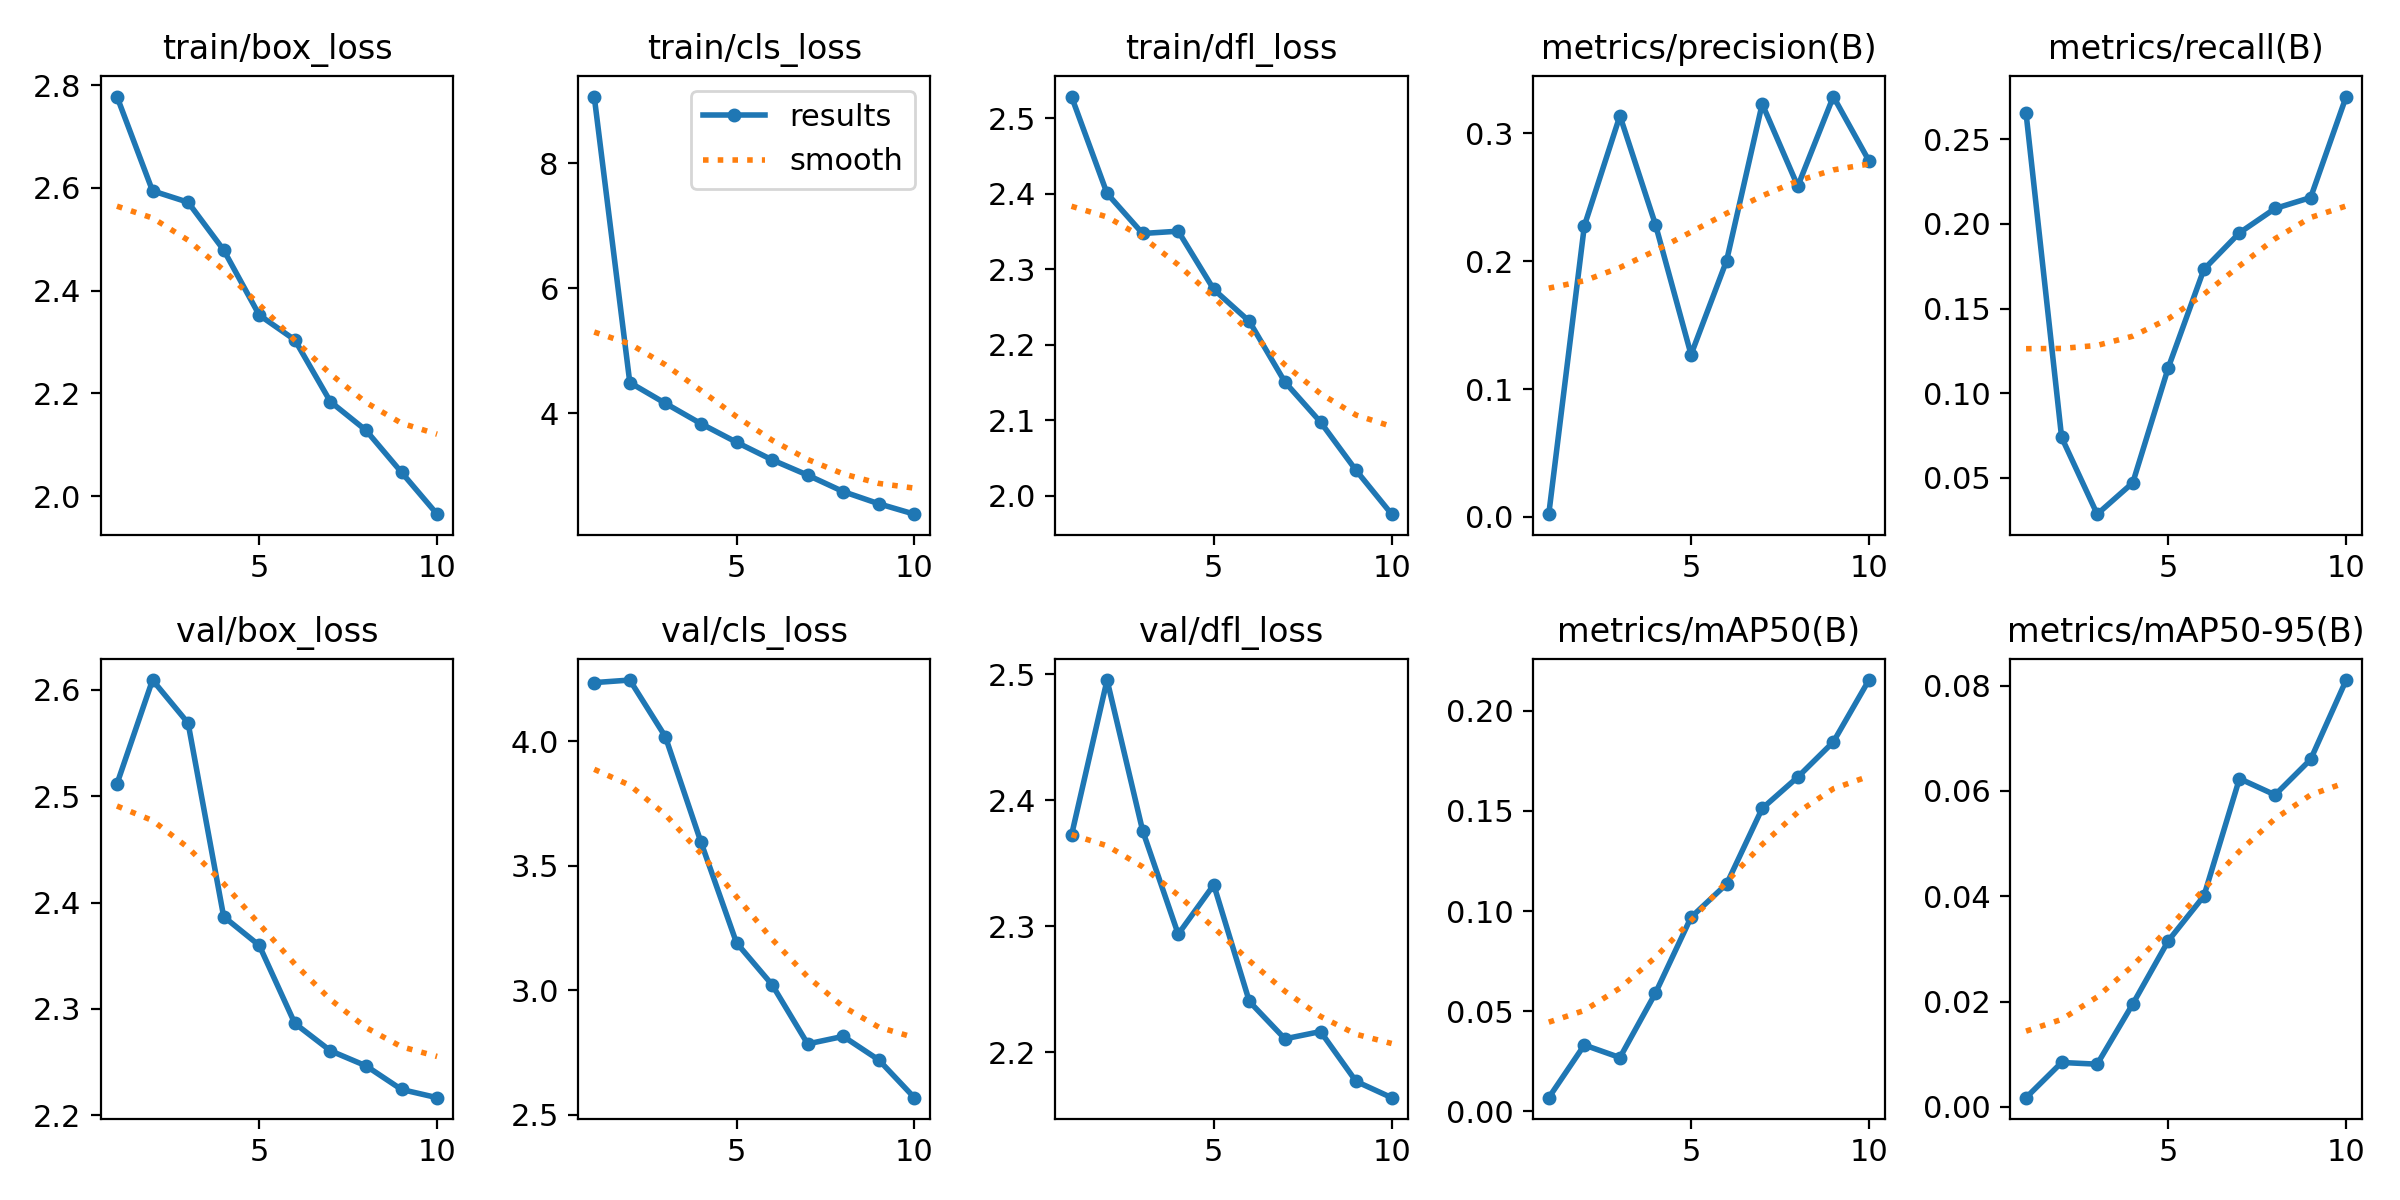

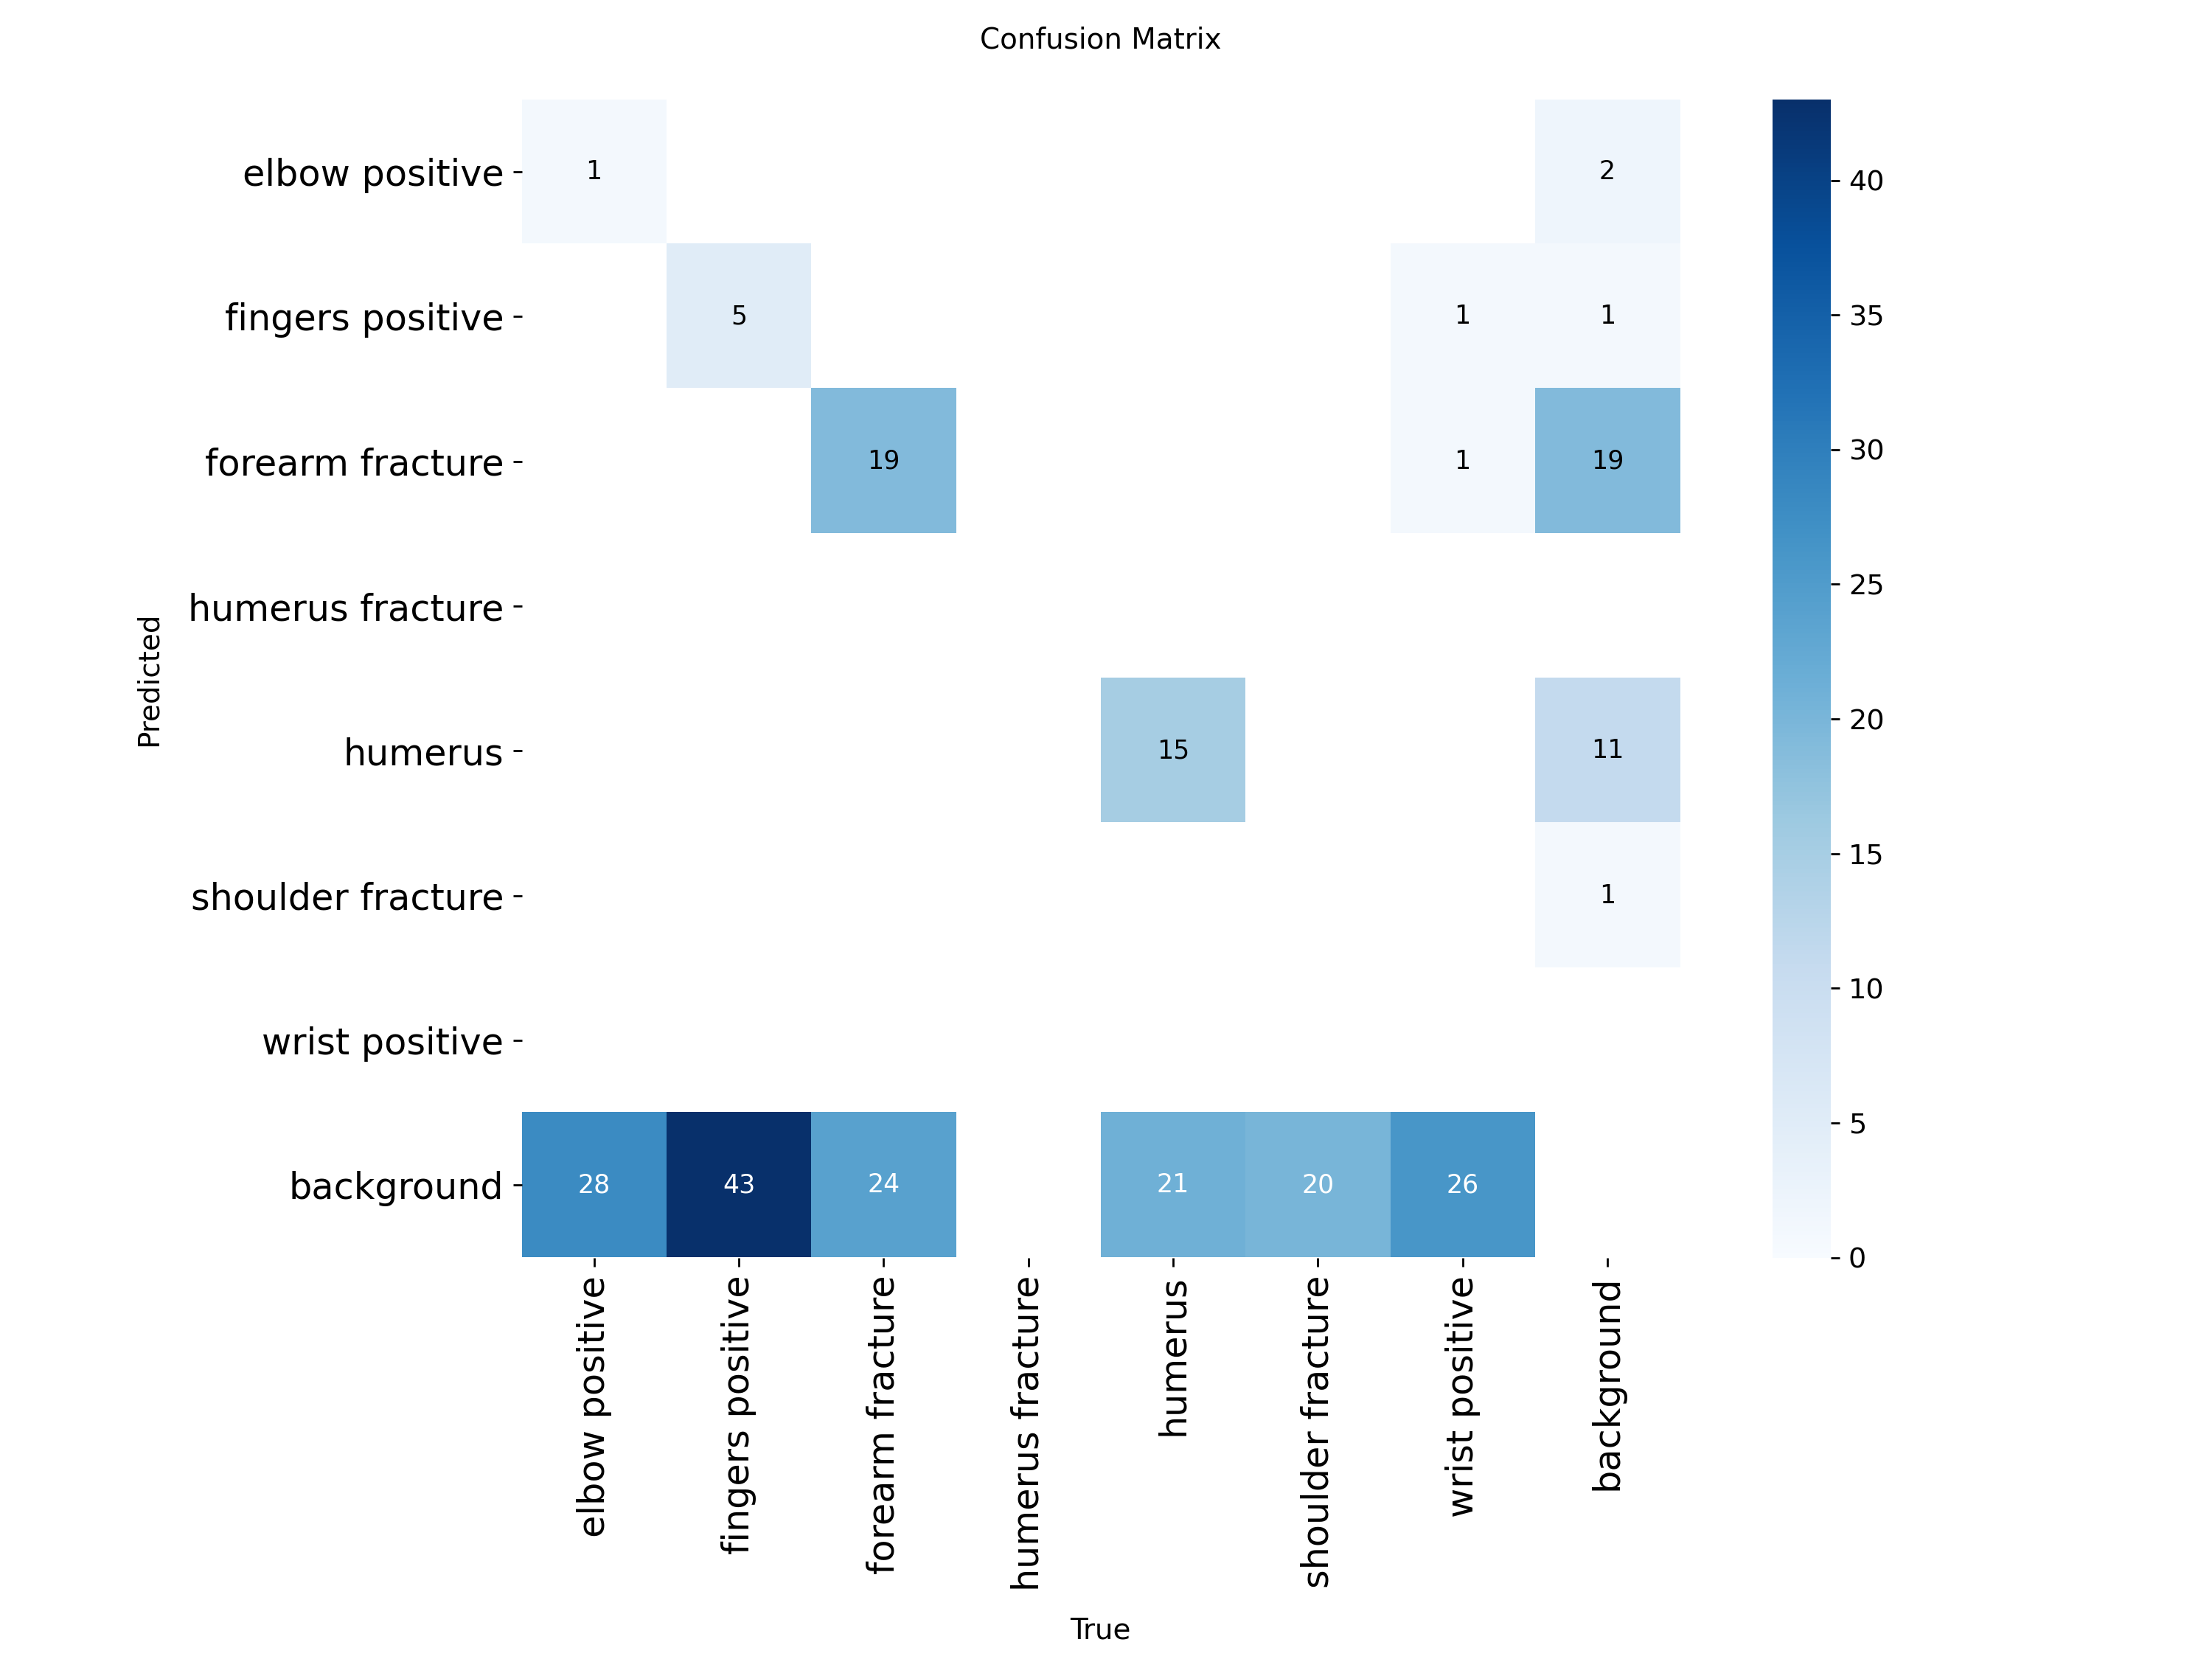

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model downloaded!


In [8]:
# View Results & Download Model
from IPython.display import Image, display
from google.colab import files

results_dir = project_dir / "yolo_training_results" / f"yolov8{MODEL_SIZE}_bone_fracture"
best_model = results_dir / "weights" / "best.pt"

print("="*80)
print("TRAINING RESULTS")
print("="*80)

if best_model.exists():
    print(f"✅ Best model: {best_model}")

    # Display results
    try:
        display(Image(f"{results_dir}/results.png"))
        display(Image(f"{results_dir}/confusion_matrix.png"))
    except Exception as e:
        print(f"⚠️  Could not display images: {e}")
        print(f"Results available in: {results_dir}")

    # Download
    files.download(str(best_model))
    print("✅ Model downloaded!")
else:
    print("⚠️  Model not found - training may still be in progress")
    print(f"Expected location: {best_model}")
